In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
anot = pd.read_csv('aneuploidy_data_NEW_COMPACT.csv',index_col=0)

In [5]:
anot_CCLE = anot.copy()
anot_CCLE.index = anot_CCLE.loc[:,'CCLE_ID']

In [6]:
from taigapy import TaigaClient
tc = TaigaClient()

gene_effect_rnai_achilles = tc.get(name='demeter2-achilles-5386', version=13, file='gene_effect')
gene_effect_rnai_drive = tc.get(name='demeter2-drive-0591', version=12, file='gene_effect')
gene_effect_crispr_achilles = tc.get(name='avana-public-tentative-19q4-c2df', version=4, file='gene_effect')

In [5]:
gene_effect_rnai_drive.isna().sum().sort_values().loc['MAD2L1 (4085)']

14

In [6]:
# need to regress out lineage before making these plots! 

sample_info = tc.get(name='internal-19q4-fb11', version=29, file='sample_info')
sample_info.index = sample_info.loc[:,'CCLE_Name'] 
sample_info = sample_info[~sample_info.index.duplicated(keep='first')]

In [7]:
sample_info_depmap = sample_info.copy()
sample_info_depmap.index = sample_info.loc[:,'DepMap_ID']#.loc[gene_effect_rnai_achilles.index,'lineage']

In [9]:
genes = ['BUB1B (701)','MAD2L1 (4085)']

In [10]:
gene_effect_rnai_drive_ = gene_effect_rnai_drive.loc[:,genes].dropna()
gene_effect_rnai_achilles_ = gene_effect_rnai_achilles.loc[:,genes].dropna()
gene_effect_crispr_achilles_ = gene_effect_crispr_achilles.loc[:,genes].dropna()



In [10]:
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

one_hot = pd.get_dummies(sample_info.loc[gene_effect_rnai_achilles.index,'lineage'])
mu = gene_effect_rnai_achilles_.mean()
reg = LinearRegression().fit(one_hot, gene_effect_rnai_achilles_)
preds = pd.DataFrame(reg.predict(one_hot),index = gene_effect_rnai_achilles_.index,columns = gene_effect_rnai_achilles_.columns)

preds_ = preds 
corrected_rnai_achilles = ((gene_effect_rnai_achilles_  - mu)- preds_)+ mu


In [11]:
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

one_hot = pd.get_dummies(sample_info_depmap.loc[gene_effect_crispr_achilles.index,'lineage'])
mu = gene_effect_crispr_achilles_.mean()
reg = LinearRegression().fit(one_hot, gene_effect_crispr_achilles_)
preds = pd.DataFrame(reg.predict(one_hot),index = gene_effect_crispr_achilles_.index,columns = gene_effect_crispr_achilles_.columns)

preds_ = preds 
corrected_crispr_achilles = ((gene_effect_crispr_achilles_ - mu) - preds_)+ mu



In [12]:
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

one_hot = pd.get_dummies(sample_info.loc[gene_effect_rnai_drive_.index,'lineage'])
mu = gene_effect_rnai_drive_.mean()
reg = LinearRegression().fit(one_hot, gene_effect_rnai_drive_)
preds = pd.DataFrame(reg.predict(one_hot),index = gene_effect_rnai_drive_.index,columns = gene_effect_rnai_drive_.columns)

preds_ = preds 
corrected_rnai_drive = ((gene_effect_rnai_drive_ - mu) - preds_)+ mu



/Users/mkazachk/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [13]:
high_aneu = anot[anot.loc[:,'many_arm_events'] == True]
low_aneu = anot[anot.loc[:,'many_arm_events'] == False]

In [14]:
# figure 1a
from cds import plotting

/Users/mkazachk/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.
No handles with labels found to put in legend.


RNAi Achilles p-value for BUB1B: 0.00039089079946320047
RNAi Achilles p-value for MAD2L1: 0.026148935841399715


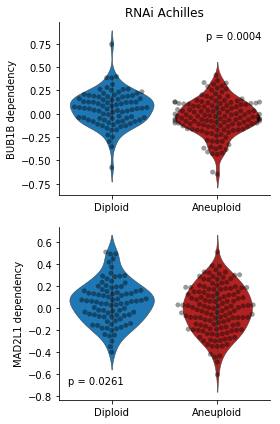

In [15]:
from scipy import stats
fig,axx = plt.subplots(2,1,figsize=(4,6))


shared = set(anot.loc[:,'CCLE_ID']) & set(corrected_rnai_achilles.index)
temp = corrected_rnai_achilles.loc[shared]
temp['ploidy'] = anot_CCLE.loc[temp.index,'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'

my_pal = {"Diploid": "C0", "Aneuploid": "firebrick"}
sns.violinplot(y = 'BUB1B (701)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[0],order=['Diploid','Aneuploid'],palette=my_pal)   
sns.swarmplot(y = 'BUB1B (701)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[0],order=['Diploid','Aneuploid'])
axx[0].set_title('RNAi Achilles')
axx[0].set_ylabel('BUB1B dependency')
axx[0].set_xlabel('')

plotting.simpleaxis(axx[0])


# plt.figure()
sns.violinplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[1],order=['Diploid','Aneuploid'],palette=my_pal)
sns.swarmplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[1],order=['Diploid','Aneuploid'])
#axx[1].set_title('RNAi Achilles')
axx[1].set_ylabel('MAD2L1 dependency')
axx[1].set_xlabel('')

plotting.simpleaxis(axx[1])
plt.tight_layout()


tt,p_val = stats.ttest_ind(corrected_rnai_achilles.loc[trus,'BUB1B (701)'],corrected_rnai_achilles.loc[falsee,'BUB1B (701)'])
print('RNAi Achilles p-value for BUB1B: ' + str(p_val))
axx[0].legend(title='p = '+ str(round(p_val,4)),frameon=False)
tt,p_val = stats.ttest_ind(corrected_rnai_achilles.loc[trus,'MAD2L1 (4085)'],corrected_rnai_achilles.loc[falsee,'MAD2L1 (4085)'])
print('RNAi Achilles p-value for MAD2L1: ' + str(p_val))
axx[1].legend(title='p = '+ str(round(p_val,4)),frameon=False)
plt.savefig('fig2a/rnai_achilles_lineage_regressed_out.pdf')
# ax = sns.violinplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,saturation=1,linewidth=.5)
# sns.swarmplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,color='black',alpha=.4)
# plt.title('RNAi Achilles')
# plt.ylabel('MAD2L1 dependency')
# plt.xlabel('')

# plotting.simpleaxis(ax)

In [16]:
temp.shape

(224, 3)

/Users/mkazachk/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.
No handles with labels found to put in legend.


RNAi Achilles p-value for BUB1B: 0.0009367718912637333
RNAi Achilles p-value for MAD2L1: 0.08826442274940652


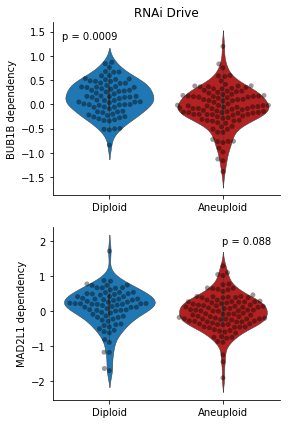

In [17]:
fig,axx = plt.subplots(2,1,figsize=(4,6))


shared = set(anot.loc[:,'CCLE_ID']) & set(corrected_rnai_drive.index)
temp = corrected_rnai_drive.loc[shared]
temp['ploidy'] = anot_CCLE.loc[temp.index,'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'


sns.violinplot(y = 'BUB1B (701)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[0],order=['Diploid','Aneuploid'],palette=my_pal)
sns.swarmplot(y = 'BUB1B (701)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[0],order=['Diploid','Aneuploid'])
axx[0].set_title('RNAi Drive')
axx[0].set_ylabel('BUB1B dependency')
axx[0].set_xlabel('')

plotting.simpleaxis(axx[0])


# plt.figure()
sns.violinplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[1],order=['Diploid','Aneuploid'],palette=my_pal)
sns.swarmplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[1],order=['Diploid','Aneuploid'])
#axx[1].set_title('RNAi drive')
axx[1].set_ylabel('MAD2L1 dependency')
axx[1].set_xlabel('')

plotting.simpleaxis(axx[1])
plt.tight_layout()



tt,p_val = stats.ttest_ind(corrected_rnai_drive.loc[trus,'BUB1B (701)'],corrected_rnai_drive.loc[falsee,'BUB1B (701)'])
print('RNAi Achilles p-value for BUB1B: ' + str(p_val))
axx[0].legend(title='p = '+ str(round(p_val,4)),frameon=False)
tt,p_val = stats.ttest_ind(corrected_rnai_drive.loc[trus,'MAD2L1 (4085)'],corrected_rnai_drive.loc[falsee,'MAD2L1 (4085)'])
print('RNAi Achilles p-value for MAD2L1: ' + str(p_val))
axx[1].legend(title='p = '+ str(round(p_val,3)),frameon=False)
plt.savefig('fig2a/rnai_drive_lineage_regressed_out.pdf')

# shared = set(anot.loc[:,'CCLE_ID']) & set(gene_effect_rnai_drive.index)
# temp = gene_effect_rnai_drive.loc[shared]
# temp['ploidy'] = anot_CCLE.loc[temp.index,'many_arm_events']

# trus = temp[temp.loc[:,'ploidy']==True].index 
# temp.loc[trus,'ploidy']= 'Aneuploid'
# falsee = temp[temp.loc[:,'ploidy']==False].index 
# temp.loc[falsee,'ploidy']=  'Diploid'


# ax = sns.violinplot(y = 'BUB1B (701)',x='ploidy', data = temp,saturation=1,linewidth=.5)
# sns.swarmplot(y = 'BUB1B (701)',x='ploidy', data = temp,color='black',alpha=.4)
# plt.title('RNAi Drive')
# plt.ylabel('BUB1B dependency')
# plt.xlabel('')

# plotting.simpleaxis(ax)

# plt.figure()

# ax = sns.violinplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,saturation=1,linewidth=.5)
# sns.swarmplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,color='black',alpha=.4)
# plt.title('RNAi Drive')
# plt.ylabel('MAD2L1 dependency')
# plt.xlabel('')

# plotting.simpleaxis(ax)

/Users/mkazachk/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.
No handles with labels found to put in legend.


RNAi Achilles p-value for BUB1B: 0.11086376401939635
RNAi Achilles p-value for MAD2L1: 0.0971128333725252


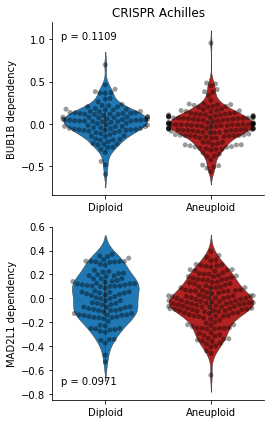

In [18]:
fig,axx = plt.subplots(2,1,figsize=(4,6))
shared = set(anot.index) & set(corrected_crispr_achilles.index)
temp = corrected_crispr_achilles.loc[shared]
temp['ploidy'] = anot.loc[temp.index,'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'



sns.violinplot(y = 'BUB1B (701)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[0],order=['Diploid','Aneuploid'],palette=my_pal)
sns.swarmplot(y = 'BUB1B (701)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[0],order=['Diploid','Aneuploid'])
axx[0].set_title('CRISPR Achilles')
axx[0].set_ylabel('BUB1B dependency')
axx[0].set_xlabel('')

plotting.simpleaxis(axx[0])


# plt.figure()
sns.violinplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[1],order=['Diploid','Aneuploid'],palette=my_pal)
sns.swarmplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[1],order=['Diploid','Aneuploid'])
#axx[1].set_title('RNAi drive')
axx[1].set_ylabel('MAD2L1 dependency')
axx[1].set_xlabel('')

plotting.simpleaxis(axx[1])
plt.tight_layout()



tt,p_val = stats.ttest_ind(corrected_crispr_achilles.loc[trus,'BUB1B (701)'],corrected_crispr_achilles.loc[falsee,'BUB1B (701)'])
print('RNAi Achilles p-value for BUB1B: ' + str(p_val))
axx[0].legend(title='p = '+ str(round(p_val,4)),frameon=False)
tt,p_val = stats.ttest_ind(corrected_crispr_achilles.loc[trus,'MAD2L1 (4085)'],corrected_crispr_achilles.loc[falsee,'MAD2L1 (4085)'])
print('RNAi Achilles p-value for MAD2L1: ' + str(p_val))
axx[1].legend(title='p = '+ str(round(p_val,4)),frameon=False)
plt.savefig('fig2a/crispr_achilles_lineage_regressed_out.pdf')


# ax = sns.violinplot(y = 'BUB1B (701)',x='ploidy', data = temp,saturation=1,linewidth=.5)
# sns.swarmplot(y = 'BUB1B (701)',x='ploidy', data = temp,color='black',alpha=.4)
# plt.title('CRISPR Achilles')
# plt.ylabel('BUB1B dependency')
# plt.xlabel('')

# plotting.simpleaxis(ax)

# plt.figure()


# ax = sns.violinplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,saturation=1,linewidth=.5)
# sns.swarmplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,color='black',alpha=.4)
# plt.title('CRISPR Achilles')
# plt.ylabel('MAD2L1 dependency')
# plt.xlabel('')
# plotting.simpleaxis(ax)

/Users/mkazachk/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.
No handles with labels found to put in legend.


RNAi Achilles p-value for BUB1B: 6.730990263948616e-07
RNAi Achilles p-value for MAD2L1: 1.7214833709957065e-07


No handles with labels found to put in legend.
No handles with labels found to put in legend.


RNAi Achilles p-value for BUB1B: 1.8203222702995302e-06
RNAi Achilles p-value for MAD2L1: 0.00012537549828545483


No handles with labels found to put in legend.
No handles with labels found to put in legend.


RNAi Achilles p-value for BUB1B: 0.10671769677384838
RNAi Achilles p-value for MAD2L1: 0.040258363077360006


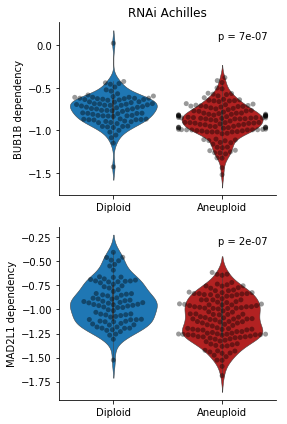

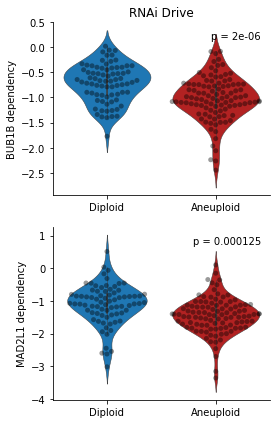

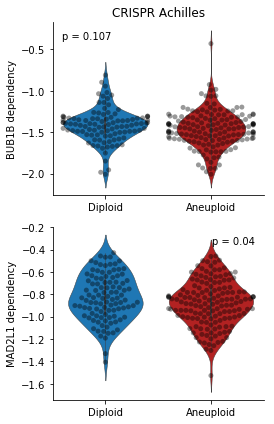

In [19]:
fig,axx = plt.subplots(2,1,figsize=(4,6))
shared = set(anot.loc[:,'CCLE_ID']) & set(gene_effect_rnai_achilles_.index)
temp = gene_effect_rnai_achilles_.loc[shared]
temp['ploidy'] = anot_CCLE.loc[temp.index,'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'

my_pal = {"Diploid": "C0", "Aneuploid": "firebrick"}
sns.violinplot(y = 'BUB1B (701)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[0],order=['Diploid','Aneuploid'],palette=my_pal)   
sns.swarmplot(y = 'BUB1B (701)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[0],order=['Diploid','Aneuploid'])
axx[0].set_title('RNAi Achilles')
axx[0].set_ylabel('BUB1B dependency')
axx[0].set_xlabel('')

plotting.simpleaxis(axx[0])


# plt.figure()
sns.violinplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[1],order=['Diploid','Aneuploid'],palette=my_pal)
sns.swarmplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[1],order=['Diploid','Aneuploid'])
#axx[1].set_title('RNAi Achilles')
axx[1].set_ylabel('MAD2L1 dependency')
axx[1].set_xlabel('')

plotting.simpleaxis(axx[1])
plt.tight_layout()


tt,p_val = stats.ttest_ind(gene_effect_rnai_achilles_.loc[trus,'BUB1B (701)'],gene_effect_rnai_achilles_.loc[falsee,'BUB1B (701)'])
print('RNAi Achilles p-value for BUB1B: ' + str(p_val))
axx[0].legend(title='p = '+ str(round(p_val,7)),frameon=False)
tt,p_val = stats.ttest_ind(gene_effect_rnai_achilles_.loc[trus,'MAD2L1 (4085)'],gene_effect_rnai_achilles_.loc[falsee,'MAD2L1 (4085)'])
print('RNAi Achilles p-value for MAD2L1: ' + str(p_val))
axx[1].legend(title='p = '+ str(round(p_val,7)),frameon=False)

plt.savefig('fig2a/rnai_achilles_orignal.pdf')



# ##########################################################################
fig,axx = plt.subplots(2,1,figsize=(4,6))


shared = set(anot.loc[:,'CCLE_ID']) & set(gene_effect_rnai_drive_.index)
temp = gene_effect_rnai_drive_.loc[shared]
temp['ploidy'] = anot_CCLE.loc[temp.index,'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'


sns.violinplot(y = 'BUB1B (701)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[0],order=['Diploid','Aneuploid'],palette=my_pal)
sns.swarmplot(y = 'BUB1B (701)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[0],order=['Diploid','Aneuploid'])
axx[0].set_title('RNAi Drive')
axx[0].set_ylabel('BUB1B dependency')
axx[0].set_xlabel('')

plotting.simpleaxis(axx[0])


# plt.figure()
sns.violinplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[1],order=['Diploid','Aneuploid'],palette=my_pal)
sns.swarmplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[1],order=['Diploid','Aneuploid'])
#axx[1].set_title('RNAi drive')
axx[1].set_ylabel('MAD2L1 dependency')
axx[1].set_xlabel('')

plotting.simpleaxis(axx[1])
plt.tight_layout()



tt,p_val = stats.ttest_ind(gene_effect_rnai_drive_.loc[trus,'BUB1B (701)'],gene_effect_rnai_drive_.loc[falsee,'BUB1B (701)'])
print('RNAi Achilles p-value for BUB1B: ' + str(p_val))
axx[0].legend(title='p = '+ str(round(p_val,6)),frameon=False)
tt,p_val = stats.ttest_ind(gene_effect_rnai_drive_.loc[trus,'MAD2L1 (4085)'],gene_effect_rnai_drive_.loc[falsee,'MAD2L1 (4085)'])
print('RNAi Achilles p-value for MAD2L1: ' + str(p_val))
axx[1].legend(title='p = '+ str(round(p_val,6)),frameon=False)
plt.savefig('fig2a/rnai_drive_orignal.pdf')

############################################################################


fig,axx = plt.subplots(2,1,figsize=(4,6))
shared = set(anot.index) & set(gene_effect_crispr_achilles_.index)
temp = gene_effect_crispr_achilles_.loc[shared]
temp['ploidy'] = anot.loc[temp.index,'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'



sns.violinplot(y = 'BUB1B (701)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[0],order=['Diploid','Aneuploid'],palette=my_pal)
sns.swarmplot(y = 'BUB1B (701)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[0],order=['Diploid','Aneuploid'])
axx[0].set_title('CRISPR Achilles')
axx[0].set_ylabel('BUB1B dependency')
axx[0].set_xlabel('')

plotting.simpleaxis(axx[0])


# plt.figure()
sns.violinplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[1],order=['Diploid','Aneuploid'],palette=my_pal)
sns.swarmplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[1],order=['Diploid','Aneuploid'])
#axx[1].set_title('RNAi drive')
axx[1].set_ylabel('MAD2L1 dependency')
axx[1].set_xlabel('')

plotting.simpleaxis(axx[1])
plt.tight_layout()



tt,p_val = stats.ttest_ind(gene_effect_crispr_achilles_.loc[trus,'BUB1B (701)'],gene_effect_crispr_achilles_.loc[falsee,'BUB1B (701)'])
print('RNAi Achilles p-value for BUB1B: ' + str(p_val))
axx[0].legend(title='p = '+ str(round(p_val,3)),frameon=False)
tt,p_val = stats.ttest_ind(gene_effect_crispr_achilles_.loc[trus,'MAD2L1 (4085)'],gene_effect_crispr_achilles_.loc[falsee,'MAD2L1 (4085)'])
print('RNAi Achilles p-value for MAD2L1: ' + str(p_val))
axx[1].legend(title='p = '+ str(round(p_val,3)),frameon=False)
plt.savefig('fig2a/crispr_achilles_original.pdf')


In [20]:
#rnai achilles


shared = set(anot.loc[:,'CCLE_ID']) & set(corrected_rnai_achilles.index)
temp = corrected_rnai_achilles.loc[shared]
temp['ploidy'] = anot_CCLE.loc[temp.index,'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'

from scipy import stats
tt,p_val = stats.ttest_ind(corrected_rnai_achilles.loc[trus,'BUB1B (701)'],corrected_rnai_achilles.loc[falsee,'BUB1B (701)'])
print('RNAi Achilles p-value for BUB1B: ' + str(p_val))

tt,p_val = stats.ttest_ind(corrected_rnai_achilles.loc[trus,'MAD2L1 (4085)'],corrected_rnai_achilles.loc[falsee,'MAD2L1 (4085)'])
print('RNAi Achilles p-value for MAD2L1: ' + str(p_val))

RNAi Achilles p-value for BUB1B: 0.00039089079946320047
RNAi Achilles p-value for MAD2L1: 0.026148935841399715


In [21]:
shared = set(anot.loc[:,'CCLE_ID']) & set(corrected_rnai_drive.index)
temp = corrected_rnai_drive.loc[shared]
temp['ploidy'] = anot_CCLE.loc[temp.index,'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'

from scipy import stats
tt,p_val = stats.ttest_ind(corrected_rnai_drive.loc[trus,'BUB1B (701)'],corrected_rnai_drive.loc[falsee,'BUB1B (701)'])
print('RNAi Drive p-value for BUB1B: ' + str(p_val))

tt,p_val = stats.ttest_ind(corrected_rnai_drive.loc[trus,'MAD2L1 (4085)'].dropna(),corrected_rnai_drive.loc[falsee,'MAD2L1 (4085)'].dropna())
print('RNAi Drive p-value for MAD2L1: ' + str(p_val))

RNAi Drive p-value for BUB1B: 0.0009367718912637333
RNAi Drive p-value for MAD2L1: 0.08826442274940652


In [22]:
shared = set(anot.index) & set(corrected_crispr_achilles.index)
temp = corrected_crispr_achilles.loc[shared]
temp['ploidy'] = anot.loc[temp.index,'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'

from scipy import stats
tt,p_val = stats.ttest_ind(corrected_crispr_achilles.loc[trus,'BUB1B (701)'],corrected_crispr_achilles.loc[falsee,'BUB1B (701)'])
print('CRISPR Achilles p-value for BUB1B: ' + str(p_val))

tt,p_val = stats.ttest_ind(corrected_crispr_achilles.loc[trus,'MAD2L1 (4085)'].dropna(),corrected_crispr_achilles.loc[falsee,'MAD2L1 (4085)'].dropna())
print('CRISPR Achilles p-value for MAD2L1: ' + str(p_val))

CRISPR Achilles p-value for BUB1B: 0.11086376401939635
CRISPR Achilles p-value for MAD2L1: 0.0971128333725252


In [12]:
from cds import plotting

/Users/mkazachk/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/Users/mkazachk/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.
No handles with labels found to put in legend.


RNAi Achilles p-value for BUB1B: 1.4101833774261156e-05
RNAi Achilles p-value for MAD2L1: 8.824068383590569e-07


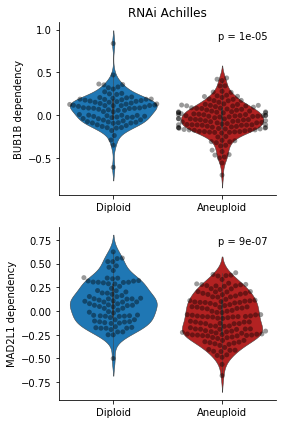

In [17]:
# want to also regress out doubling time
#rnai achilles

from sklearn.linear_model import LinearRegression


for_doubling = anot_CCLE.loc[gene_effect_rnai_achilles_.index,'RNAi_doubling_time'].dropna().index


mu = gene_effect_rnai_achilles_.loc[for_doubling,genes].mean()
reg = LinearRegression().fit(np.array(anot_CCLE.loc[for_doubling,'RNAi_doubling_time']).reshape(-1, 1), gene_effect_rnai_achilles_.loc[for_doubling])
preds = pd.DataFrame(reg.predict(np.array(anot_CCLE.loc[for_doubling,'RNAi_doubling_time']).reshape(-1,1)),index = for_doubling,columns = gene_effect_rnai_achilles_.columns)

preds_ = preds 
corrected_rnai_achilles_doubling_time = ((gene_effect_rnai_achilles_.loc[for_doubling] - mu) - preds_)+ mu







fig,axx = plt.subplots(2,1,figsize=(4,6))


shared = set(anot.loc[:,'CCLE_ID']) & set(corrected_rnai_achilles_doubling_time.index)
temp = corrected_rnai_achilles_doubling_time.loc[shared]
temp['ploidy'] = anot_CCLE.loc[temp.index,'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'

my_pal = {"Diploid": "C0", "Aneuploid": "firebrick"}
sns.violinplot(y = 'BUB1B (701)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[0],order=['Diploid','Aneuploid'],palette=my_pal)   
sns.swarmplot(y = 'BUB1B (701)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[0],order=['Diploid','Aneuploid'])
axx[0].set_title('RNAi Achilles')
axx[0].set_ylabel('BUB1B dependency')
axx[0].set_xlabel('')

plotting.simpleaxis(axx[0])


# plt.figure()
sns.violinplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[1],order=['Diploid','Aneuploid'],palette=my_pal)
sns.swarmplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[1],order=['Diploid','Aneuploid'])
#axx[1].set_title('RNAi Achilles')
axx[1].set_ylabel('MAD2L1 dependency')
axx[1].set_xlabel('')

plotting.simpleaxis(axx[1])
plt.tight_layout()




from scipy import stats
tt,p_val = stats.ttest_ind(corrected_rnai_achilles_doubling_time.loc[trus,'BUB1B (701)'],corrected_rnai_achilles_doubling_time.loc[falsee,'BUB1B (701)'])
print('RNAi Achilles p-value for BUB1B: ' + str(p_val))
axx[0].legend(title='p = '+ str(round(p_val,5)),frameon=False)
tt,p_val = stats.ttest_ind(corrected_rnai_achilles_doubling_time.loc[trus,'MAD2L1 (4085)'],corrected_rnai_achilles_doubling_time.loc[falsee,'MAD2L1 (4085)'])
print('RNAi Achilles p-value for MAD2L1: ' + str(p_val))
axx[1].legend(title='p = '+ str(round(p_val,7)),frameon=False)
plt.savefig('fig2a/rnai_achilles_doubling_time_regressed_out.pdf')

In [19]:
corrected_rnai_achilles_doubling_time

,BUB1B (701),MAD2L1 (4085)
22RV1_PROSTATE,0.162554,0.077561
2313287_STOMACH,0.180868,0.125577
697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.355711,0.557851
769P_KIDNEY,-0.093588,-0.165054
786O_KIDNEY,-0.130148,0.172288
...,...,...
WM115_SKIN,-0.001417,-0.501038
WM1799_SKIN,0.186167,-0.191656
WM793_SKIN,-0.144957,-0.176119
WM983B_SKIN,-0.181506,-0.038603


/Users/mkazachk/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/Users/mkazachk/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.
No handles with labels found to put in legend.


RNAi Drive p-value for BUB1B: 4.292273720120343e-05
RNAi Drive p-value for MAD2L1: 0.0015264360058992352


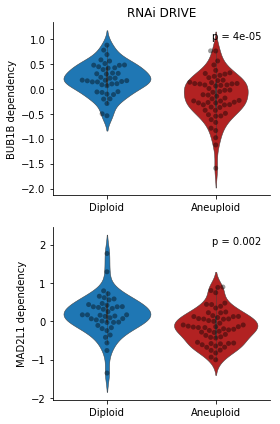

In [15]:
# want to also regress out doubling time
#rnai_drive

from sklearn.linear_model import LinearRegression


for_doubling = anot_CCLE.loc[gene_effect_rnai_drive_.index,'RNAi_doubling_time'].dropna().index


mu = gene_effect_rnai_drive_.loc[for_doubling].mean()
reg = LinearRegression().fit(np.array(anot_CCLE.loc[for_doubling,'RNAi_doubling_time']).reshape(-1, 1), gene_effect_rnai_drive_.loc[for_doubling])
preds = pd.DataFrame(reg.predict(np.array(anot_CCLE.loc[for_doubling,'RNAi_doubling_time']).reshape(-1,1)),index = for_doubling,columns = gene_effect_rnai_drive_.columns)

preds_ = preds 
corrected_rnai_drive_doubling_time = ((gene_effect_rnai_drive_.loc[for_doubling] -mu )- preds_)+ mu







fig,axx = plt.subplots(2,1,figsize=(4,6))


shared = set(anot.loc[:,'CCLE_ID']) & set(corrected_rnai_drive_doubling_time.index)
temp = corrected_rnai_drive_doubling_time.loc[shared]
temp['ploidy'] = anot_CCLE.loc[temp.index,'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'

my_pal = {"Diploid": "C0", "Aneuploid": "firebrick"}
sns.violinplot(y = 'BUB1B (701)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[0],order=['Diploid','Aneuploid'],palette=my_pal)   
sns.swarmplot(y = 'BUB1B (701)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[0],order=['Diploid','Aneuploid'])
axx[0].set_title('RNAi DRIVE')
axx[0].set_ylabel('BUB1B dependency')
axx[0].set_xlabel('')

plotting.simpleaxis(axx[0])


# plt.figure()
sns.violinplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[1],order=['Diploid','Aneuploid'],palette=my_pal)
sns.swarmplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[1],order=['Diploid','Aneuploid'])
#axx[1].set_title('RNAi Achilles')
axx[1].set_ylabel('MAD2L1 dependency')
axx[1].set_xlabel('')

plotting.simpleaxis(axx[1])
plt.tight_layout()




from scipy import stats
tt,p_val = stats.ttest_ind(corrected_rnai_drive_doubling_time.loc[trus,'BUB1B (701)'],corrected_rnai_drive_doubling_time.loc[falsee,'BUB1B (701)'])
print('RNAi Drive p-value for BUB1B: ' + str(p_val))
axx[0].legend(title='p = '+ str(round(p_val,5)),frameon=False)
tt,p_val = stats.ttest_ind(corrected_rnai_drive_doubling_time.loc[trus,'MAD2L1 (4085)'].dropna(),corrected_rnai_drive_doubling_time.loc[falsee,'MAD2L1 (4085)'].dropna())
print('RNAi Drive p-value for MAD2L1: ' + str(p_val))
axx[1].legend(title='p = '+ str(round(p_val,3)),frameon=False)
plt.savefig('fig2a/rnai_drive_doubling_time_regressed_out.pdf')

/Users/mkazachk/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/Users/mkazachk/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.
No handles with labels found to put in legend.


CRISPR Achilles p-value for BUB1B: 0.09950483996481145
CRISPR Achilles p-value for MAD2L1: 0.38262084092164317


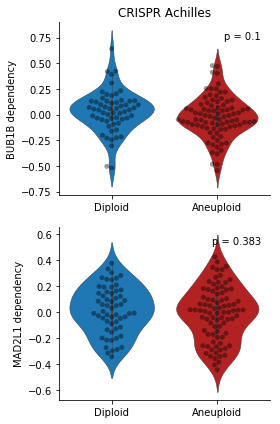

In [25]:
# want to also regress out doubling time
#crispr_achilles

from sklearn.linear_model import LinearRegression


for_doubling = anot.loc[gene_effect_crispr_achilles_.index,'RNAi_doubling_time'].dropna().index


mu = gene_effect_crispr_achilles_.loc[for_doubling].mean()
reg = LinearRegression().fit(np.array(anot.loc[for_doubling,'RNAi_doubling_time']).reshape(-1, 1), gene_effect_crispr_achilles_.loc[for_doubling] )
preds = pd.DataFrame(reg.predict(np.array(anot.loc[for_doubling,'RNAi_doubling_time']).reshape(-1,1)),index = for_doubling,columns = gene_effect_crispr_achilles_.columns)

preds_ = preds 
corrected_crispr_achilles_doubling_time = ((gene_effect_crispr_achilles_.loc[for_doubling] - mu) - preds_)+ mu







fig,axx = plt.subplots(2,1,figsize=(4,6))


shared = set(anot.index) & set(corrected_crispr_achilles_doubling_time.index)
temp = corrected_crispr_achilles_doubling_time.loc[shared]
temp['ploidy'] = anot.loc[temp.index,'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'

my_pal = {"Diploid": "C0", "Aneuploid": "firebrick"}
sns.violinplot(y = 'BUB1B (701)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[0],order=['Diploid','Aneuploid'],palette=my_pal)   
sns.swarmplot(y = 'BUB1B (701)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[0],order=['Diploid','Aneuploid'])
axx[0].set_title('CRISPR Achilles')
axx[0].set_ylabel('BUB1B dependency')
axx[0].set_xlabel('')

plotting.simpleaxis(axx[0])


# plt.figure()
sns.violinplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[1],order=['Diploid','Aneuploid'],palette=my_pal)
sns.swarmplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[1],order=['Diploid','Aneuploid'])
#axx[1].set_title('RNAi Achilles')
axx[1].set_ylabel('MAD2L1 dependency')
axx[1].set_xlabel('')

plotting.simpleaxis(axx[1])
plt.tight_layout()



tt,p_val = stats.ttest_ind(corrected_crispr_achilles_doubling_time.loc[trus,'BUB1B (701)'],corrected_crispr_achilles_doubling_time.loc[falsee,'BUB1B (701)'])
print('CRISPR Achilles p-value for BUB1B: ' + str(p_val))
axx[0].legend(title='p = '+ str(round(p_val,3)),frameon=False)
tt,p_val = stats.ttest_ind(corrected_crispr_achilles_doubling_time.loc[trus,'MAD2L1 (4085)'].dropna(),corrected_crispr_achilles_doubling_time.loc[falsee,'MAD2L1 (4085)'].dropna())
print('CRISPR Achilles p-value for MAD2L1: ' + str(p_val))
axx[1].legend(title='p = '+ str(round(p_val,3)),frameon=False)
plt.savefig('fig2a/crispr_achilles_doubling_time_regressed_out.pdf')

In [26]:
# now make signatures for HET70 and CIN70

In [27]:
public_19Q4_proteincoding_tpm = tc.get(name='depmap-rnaseq-expression-data-ccd0', version=16, file='public_19Q4_proteincoding_tpm')

In [28]:
public_19Q4_proteincoding_tpm.columns = public_19Q4_proteincoding_tpm.columns.str.split(' ').str[0]

In [29]:
cin70 = pd.read_csv('cin70genes.csv',index_col=0,header=None)
het70 = pd.read_csv('het70genes.csv')

In [30]:
big_list_cin70 = []




for i in range(1,14,2):
    big_list_cin70+= list(cin70.index.str.split(' ').str[i].dropna())

In [31]:
list_cin70 = ['TPX2',
 'PRC1',
 'FOXM1',
 'CDC2',
 'TGIF2',
 'MCM2',
 'H2AFZ',
 'TOP2A',
 'PCNA',
 'UBE2C',
 'MELK',
 'TRIP13',
 'CNAP1',
 'MCM7',
 'RNASEH2A',
 'CDC45L',
 'ESPL1',
 'FEN1',
 'CCT5',
 'ATAD2',
 'NUP205',
 'CKS2',
 'ELAVL1',
 'RRM1',
 'AURKB',
 'CTPS',
 'OIP5',
 'PTTG1',
 'MCM10',
 'MTB',
 'ASF1B',
 'CDC6',
 'ACTL6A',
 'GPI',
 'HDGF',
 'NXT1',
 'NEK2',
 'DHCR7',
 'NDUFAB1',
 'KIAA0286',
 'KIF4A',
 'RAD51AP1',
 'MAD2L1',
 'CCNB2',
 'TTK',
 'RFC4',
 'ch-TOG',
 'CDC20',
 'RRM2',
 'CCNB1',
 'MSH6',
 'DKC1',
 'CDCA8',
 'CEP55',
 'LSM4',
 'ZWINT',
 'UNG',
 'SFRS2',
 'STK6',
 'KIF20A',
 'EZH2',
 'H2AFX',
 'TOPK',
 'MTCH2',
 'CMAS',
 'FLJ10036',
 'RAD21',
 'BRRN1',
 'CDCA3',
 'ECT2']

In [32]:
het70_genes = het70.drop([0]).values[:,0]



In [33]:
# now create our signature scores

cin70_scores = public_19Q4_proteincoding_tpm.loc[:,list_cin70].mean(axis=1)
het70_scores = public_19Q4_proteincoding_tpm.loc[:,het70_genes].mean(axis=1)

/Users/mkazachk/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [34]:
public_19Q4_proteincoding_tpm_CCLE = public_19Q4_proteincoding_tpm.copy()

public_19Q4_proteincoding_tpm_CCLE.index = sample_info_depmap.loc[public_19Q4_proteincoding_tpm_CCLE.index,'CCLE_Name']

In [35]:
cin70_scores_CCLE = public_19Q4_proteincoding_tpm_CCLE.loc[:,list_cin70].mean(axis=1)
het70_scores_CCLE = public_19Q4_proteincoding_tpm_CCLE.loc[:,het70_genes].mean(axis=1)

/Users/mkazachk/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


/Users/mkazachk/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.
No handles with labels found to put in legend.


RNAi Achilles p-value for BUB1B: 8.799107845049004e-07
RNAi Achilles p-value for MAD2L1: 8.419702531747605e-06


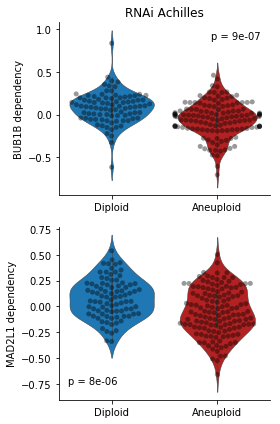

In [36]:
# want to also regress out Het70 scores
#rnai achilles

for_het = anot_CCLE.index & gene_effect_rnai_achilles_.index & het70_scores_CCLE.index


mu = gene_effect_rnai_achilles_.loc[for_het].mean()
reg = LinearRegression().fit(np.array(het70_scores_CCLE.loc[for_het]).reshape(-1, 1), gene_effect_rnai_achilles_.loc[for_het])
preds = pd.DataFrame(reg.predict(np.array(het70_scores_CCLE.loc[for_het]).reshape(-1,1)),index = for_het,columns = gene_effect_rnai_achilles_.columns)

preds_ = preds 
corrected_rnai_achilles_het_70 = ((gene_effect_rnai_achilles_.loc[for_het] - mu) - preds_)+ mu







fig,axx = plt.subplots(2,1,figsize=(4,6))


shared = set(anot.loc[:,'CCLE_ID']) & set(corrected_rnai_achilles_het_70.index)
temp = corrected_rnai_achilles_het_70.loc[shared]
temp['ploidy'] = anot_CCLE.loc[temp.index,'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'

my_pal = {"Diploid": "C0", "Aneuploid": "firebrick"}
sns.violinplot(y = 'BUB1B (701)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[0],order=['Diploid','Aneuploid'],palette=my_pal)   
sns.swarmplot(y = 'BUB1B (701)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[0],order=['Diploid','Aneuploid'])
axx[0].set_title('RNAi Achilles')
axx[0].set_ylabel('BUB1B dependency')
axx[0].set_xlabel('')

plotting.simpleaxis(axx[0])


# plt.figure()
sns.violinplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[1],order=['Diploid','Aneuploid'],palette=my_pal)
sns.swarmplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[1],order=['Diploid','Aneuploid'])
#axx[1].set_title('RNAi Achilles')
axx[1].set_ylabel('MAD2L1 dependency')
axx[1].set_xlabel('')

plotting.simpleaxis(axx[1])
plt.tight_layout()




from scipy import stats
tt,p_val = stats.ttest_ind(corrected_rnai_achilles_het_70.loc[trus,'BUB1B (701)'],corrected_rnai_achilles_het_70.loc[falsee,'BUB1B (701)'])
print('RNAi Achilles p-value for BUB1B: ' + str(p_val))
axx[0].legend(title='p = '+ str(round(p_val,7)),frameon=False)
tt,p_val = stats.ttest_ind(corrected_rnai_achilles_het_70.loc[trus,'MAD2L1 (4085)'],corrected_rnai_achilles_het_70.loc[falsee,'MAD2L1 (4085)'])
print('RNAi Achilles p-value for MAD2L1: ' + str(p_val))
axx[1].legend(title='p = '+ str(round(p_val,6)),frameon=False)
plt.savefig('fig2a/rnai_achilles_het_70_regressed_out.pdf')

/Users/mkazachk/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.
No handles with labels found to put in legend.


RNAi DRIVE p-value for BUB1B: 4.598014216115774e-07
RNAi DRIVE p-value for MAD2L1: 0.0008884262738589331


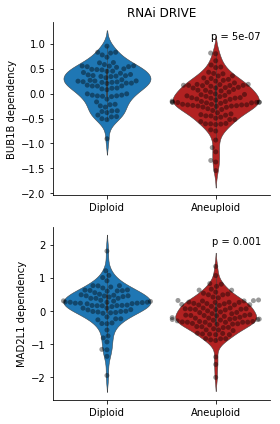

In [37]:
# want to also regress out Het70 scores
#rnai_drive

for_het = anot_CCLE.index & gene_effect_rnai_drive_.index & het70_scores_CCLE.index


mu = gene_effect_rnai_drive_.loc[for_het].mean()
reg = LinearRegression().fit(np.array(het70_scores_CCLE.loc[for_het]).reshape(-1, 1), gene_effect_rnai_drive_.loc[for_het] )
preds = pd.DataFrame(reg.predict(np.array(het70_scores_CCLE.loc[for_het]).reshape(-1,1)),index = for_het,columns = gene_effect_rnai_drive_.columns)

preds_ = preds 
corrected_rnai_drive_het_70 = ((gene_effect_rnai_drive_.loc[for_het] - mu) - preds_)+ mu







fig,axx = plt.subplots(2,1,figsize=(4,6))


shared = set(anot.loc[:,'CCLE_ID']) & set(corrected_rnai_drive_het_70.index)
temp = corrected_rnai_drive_het_70.loc[shared]
temp['ploidy'] = anot_CCLE.loc[temp.index,'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'

my_pal = {"Diploid": "C0", "Aneuploid": "firebrick"}
sns.violinplot(y = 'BUB1B (701)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[0],order=['Diploid','Aneuploid'],palette=my_pal)   
sns.swarmplot(y = 'BUB1B (701)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[0],order=['Diploid','Aneuploid'])
axx[0].set_title('RNAi DRIVE')
axx[0].set_ylabel('BUB1B dependency')
axx[0].set_xlabel('')

plotting.simpleaxis(axx[0])


# plt.figure()
sns.violinplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[1],order=['Diploid','Aneuploid'],palette=my_pal)
sns.swarmplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[1],order=['Diploid','Aneuploid'])
#axx[1].set_title('RNAi Achilles')
axx[1].set_ylabel('MAD2L1 dependency')
axx[1].set_xlabel('')

plotting.simpleaxis(axx[1])
plt.tight_layout()




from scipy import stats
tt,p_val = stats.ttest_ind(corrected_rnai_drive_het_70.loc[trus,'BUB1B (701)'],corrected_rnai_drive_het_70.loc[falsee,'BUB1B (701)'])
print('RNAi DRIVE p-value for BUB1B: ' + str(p_val))
axx[0].legend(title='p = '+ str(round(p_val,7)),frameon=False)
tt,p_val = stats.ttest_ind(corrected_rnai_drive_het_70.loc[trus,'MAD2L1 (4085)'],corrected_rnai_drive_het_70.loc[falsee,'MAD2L1 (4085)'])
print('RNAi DRIVE p-value for MAD2L1: ' + str(p_val))
axx[1].legend(title='p = '+ str(round(p_val,3)),frameon=False)

plt.savefig('fig2a/rnai_drive_het_70_regressed_out.pdf')

/Users/mkazachk/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.
No handles with labels found to put in legend.


CRISPR Achilles p-value for BUB1B: 0.02134546601860353
CRISPR Achilles p-value for MAD2L1: 0.024995070456839935


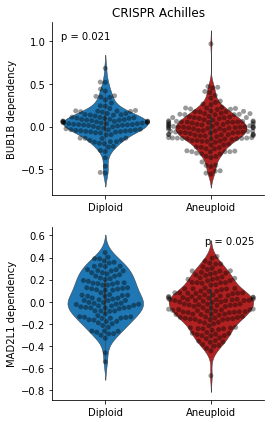

In [38]:
# want to also regress out Het70 scores
#crispr_achilles

for_het = anot.index & gene_effect_crispr_achilles_.index & het70_scores.index


mu = gene_effect_crispr_achilles_.loc[for_het].mean()
reg = LinearRegression().fit(np.array(het70_scores.loc[for_het]).reshape(-1, 1), gene_effect_crispr_achilles_.loc[for_het] )
preds = pd.DataFrame(reg.predict(np.array(het70_scores.loc[for_het]).reshape(-1,1)),index = for_het,columns = gene_effect_crispr_achilles_.columns)

preds_ = preds 
corrected_crispr_achilles_het_70 = ((gene_effect_crispr_achilles_.loc[for_het] - mu) - preds_)+ mu







fig,axx = plt.subplots(2,1,figsize=(4,6))


shared = set(anot.index) & set(corrected_crispr_achilles_het_70.index)
temp = corrected_crispr_achilles_het_70.loc[shared]
temp['ploidy'] = anot.loc[temp.index,'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'

my_pal = {"Diploid": "C0", "Aneuploid": "firebrick"}
sns.violinplot(y = 'BUB1B (701)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[0],order=['Diploid','Aneuploid'],palette=my_pal)   
sns.swarmplot(y = 'BUB1B (701)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[0],order=['Diploid','Aneuploid'])
axx[0].set_title('CRISPR Achilles')
axx[0].set_ylabel('BUB1B dependency')
axx[0].set_xlabel('')

plotting.simpleaxis(axx[0])


# plt.figure()
sns.violinplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[1],order=['Diploid','Aneuploid'],palette=my_pal)
sns.swarmplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[1],order=['Diploid','Aneuploid'])
#axx[1].set_title('RNAi Achilles')
axx[1].set_ylabel('MAD2L1 dependency')
axx[1].set_xlabel('')

plotting.simpleaxis(axx[1])
plt.tight_layout()




from scipy import stats
tt,p_val = stats.ttest_ind(corrected_crispr_achilles_het_70.loc[trus,'BUB1B (701)'],corrected_crispr_achilles_het_70.loc[falsee,'BUB1B (701)'])
print('CRISPR Achilles p-value for BUB1B: ' + str(p_val))
axx[0].legend(title='p = '+ str(round(p_val,3)),frameon=False)
tt,p_val = stats.ttest_ind(corrected_crispr_achilles_het_70.loc[trus,'MAD2L1 (4085)'],corrected_crispr_achilles_het_70.loc[falsee,'MAD2L1 (4085)'])
print('CRISPR Achilles p-value for MAD2L1: ' + str(p_val))
axx[1].legend(title='p = '+ str(round(p_val,3)),frameon=False)
plt.savefig('fig2a/crispr_achilles_het_70_regressed_out.pdf')



/Users/mkazachk/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.
No handles with labels found to put in legend.


RNAi DRIVE p-value for BUB1B: 2.774533240124996e-07
RNAi DRIVE p-value for MAD2L1: 1.0708075768488081e-07


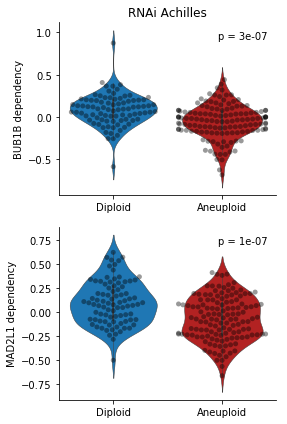

In [39]:
# want to also regress out cin70 scores
#rnai_achilles

for_cin = anot_CCLE.index & gene_effect_rnai_achilles_.index & cin70_scores_CCLE.index


mu = gene_effect_rnai_achilles_.loc[for_cin].mean()
reg = LinearRegression().fit(np.array(cin70_scores_CCLE.loc[for_cin]).reshape(-1, 1), gene_effect_rnai_achilles_.loc[for_cin] )
preds = pd.DataFrame(reg.predict(np.array(cin70_scores_CCLE.loc[for_cin]).reshape(-1,1)),index = for_cin,columns = gene_effect_rnai_achilles_.columns)

preds_ = preds 
corrected_rnai_achilles_cin_70 = ((gene_effect_rnai_achilles_.loc[for_cin] - mu) - preds_)+ mu







fig,axx = plt.subplots(2,1,figsize=(4,6))


shared = set(anot.loc[:,'CCLE_ID']) & set(corrected_rnai_achilles_cin_70.index)
temp = corrected_rnai_achilles_cin_70.loc[shared]
temp['ploidy'] = anot_CCLE.loc[temp.index,'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'

my_pal = {"Diploid": "C0", "Aneuploid": "firebrick"}
sns.violinplot(y = 'BUB1B (701)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[0],order=['Diploid','Aneuploid'],palette=my_pal)   
sns.swarmplot(y = 'BUB1B (701)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[0],order=['Diploid','Aneuploid'])
axx[0].set_title('RNAi Achilles')
axx[0].set_ylabel('BUB1B dependency')
axx[0].set_xlabel('')

plotting.simpleaxis(axx[0])


# plt.figure()
sns.violinplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[1],order=['Diploid','Aneuploid'],palette=my_pal)
sns.swarmplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[1],order=['Diploid','Aneuploid'])
#axx[1].set_title('RNAi Achilles')
axx[1].set_ylabel('MAD2L1 dependency')
axx[1].set_xlabel('')

plotting.simpleaxis(axx[1])
plt.tight_layout()




from scipy import stats
tt,p_val = stats.ttest_ind(corrected_rnai_achilles_cin_70.loc[trus,'BUB1B (701)'],corrected_rnai_achilles_cin_70.loc[falsee,'BUB1B (701)'])
print('RNAi DRIVE p-value for BUB1B: ' + str(p_val))
axx[0].legend(title='p = '+ str(round(p_val,7)),frameon=False)
tt,p_val = stats.ttest_ind(corrected_rnai_achilles_cin_70.loc[trus,'MAD2L1 (4085)'],corrected_rnai_achilles_cin_70.loc[falsee,'MAD2L1 (4085)'])
print('RNAi DRIVE p-value for MAD2L1: ' + str(p_val))

axx[1].legend(title='p = '+ str(round(p_val,7)),frameon=False)
plt.savefig('fig2a/rnai_achilles_cin_70_regressed_out.pdf')


/Users/mkazachk/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.
No handles with labels found to put in legend.


RNAi DRIVE p-value for BUB1B: 1.965871654828632e-07
RNAi DRIVE p-value for MAD2L1: 2.638050679941164e-05


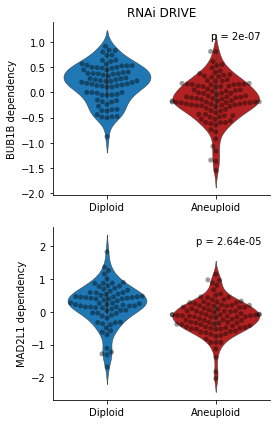

In [40]:
# want to also regress out cin70 scores
#rnai_drive

for_cin = anot_CCLE.index & gene_effect_rnai_drive_.index & cin70_scores_CCLE.index


mu = gene_effect_rnai_drive_.loc[for_cin].mean()
reg = LinearRegression().fit(np.array(cin70_scores_CCLE.loc[for_cin]).reshape(-1, 1), gene_effect_rnai_drive_.loc[for_cin])
preds = pd.DataFrame(reg.predict(np.array(cin70_scores_CCLE.loc[for_cin]).reshape(-1,1)),index = for_cin,columns = gene_effect_rnai_drive_.columns)

preds_ = preds 
corrected_rnai_drive_cin_70 = ((gene_effect_rnai_drive_.loc[for_cin] - mu) - preds_)+ mu







fig,axx = plt.subplots(2,1,figsize=(4,6))


shared = set(anot.loc[:,'CCLE_ID']) & set(corrected_rnai_drive_cin_70.index)
temp = corrected_rnai_drive_cin_70.loc[shared]
temp['ploidy'] = anot_CCLE.loc[temp.index,'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'

my_pal = {"Diploid": "C0", "Aneuploid": "firebrick"}
sns.violinplot(y = 'BUB1B (701)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[0],order=['Diploid','Aneuploid'],palette=my_pal)   
sns.swarmplot(y = 'BUB1B (701)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[0],order=['Diploid','Aneuploid'])
axx[0].set_title('RNAi DRIVE')
axx[0].set_ylabel('BUB1B dependency')
axx[0].set_xlabel('')

plotting.simpleaxis(axx[0])


# plt.figure()
sns.violinplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[1],order=['Diploid','Aneuploid'],palette=my_pal)
sns.swarmplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[1],order=['Diploid','Aneuploid'])
#axx[1].set_title('RNAi Achilles')
axx[1].set_ylabel('MAD2L1 dependency')
axx[1].set_xlabel('')

plotting.simpleaxis(axx[1])
plt.tight_layout()




from scipy import stats
tt,p_val = stats.ttest_ind(corrected_rnai_drive_cin_70.loc[trus,'BUB1B (701)'],corrected_rnai_drive_cin_70.loc[falsee,'BUB1B (701)'])
print('RNAi DRIVE p-value for BUB1B: ' + str(p_val))
axx[0].legend(title='p = '+ str(round(p_val,7)),frameon=False)
tt,p_val = stats.ttest_ind(corrected_rnai_drive_cin_70.loc[trus,'MAD2L1 (4085)'],corrected_rnai_drive_cin_70.loc[falsee,'MAD2L1 (4085)'])
print('RNAi DRIVE p-value for MAD2L1: ' + str(p_val))
axx[1].legend(title='p = '+ str(round(p_val,7)),frameon=False)


plt.savefig('fig2a/rnai_drive_cin_70_regressed_out.pdf')

/Users/mkazachk/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.
No handles with labels found to put in legend.


CRISPR Achilles p-value for BUB1B: 0.10995596932261432
CRISPR Achilles p-value for MAD2L1: 0.039224536824494755


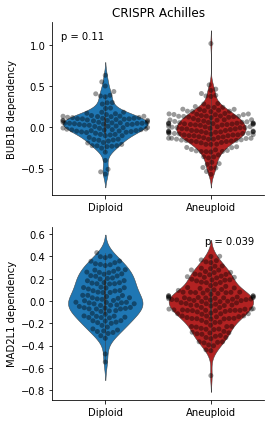

In [41]:
# want to also regress out cin70 scores
#crispr_achilles

for_cin = anot.index & gene_effect_crispr_achilles_.index & cin70_scores.index


mu = gene_effect_crispr_achilles_.loc[for_cin].mean()
reg = LinearRegression().fit(np.array(cin70_scores.loc[for_cin]).reshape(-1, 1), gene_effect_crispr_achilles_.loc[for_cin])
preds = pd.DataFrame(reg.predict(np.array(cin70_scores.loc[for_cin]).reshape(-1,1)),index = for_cin,columns = gene_effect_crispr_achilles_.columns)

preds_ = preds 
corrected_crispr_achilles_cin_70 = ((gene_effect_crispr_achilles_.loc[for_cin] - mu) - preds_)+ mu







fig,axx = plt.subplots(2,1,figsize=(4,6))


shared = set(anot.index) & set(corrected_crispr_achilles_cin_70.index)
temp = corrected_crispr_achilles_cin_70.loc[shared]
temp['ploidy'] = anot.loc[temp.index,'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'

my_pal = {"Diploid": "C0", "Aneuploid": "firebrick"}
sns.violinplot(y = 'BUB1B (701)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[0],order=['Diploid','Aneuploid'],palette=my_pal)   
sns.swarmplot(y = 'BUB1B (701)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[0],order=['Diploid','Aneuploid'])
axx[0].set_title('CRISPR Achilles')
axx[0].set_ylabel('BUB1B dependency')
axx[0].set_xlabel('')

plotting.simpleaxis(axx[0])


# plt.figure()
sns.violinplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx[1],order=['Diploid','Aneuploid'],palette=my_pal)
sns.swarmplot(y = 'MAD2L1 (4085)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx[1],order=['Diploid','Aneuploid'])
#axx[1].set_title('RNAi Achilles')
axx[1].set_ylabel('MAD2L1 dependency')
axx[1].set_xlabel('')

plotting.simpleaxis(axx[1])
plt.tight_layout()




from scipy import stats
tt,p_val = stats.ttest_ind(corrected_crispr_achilles_cin_70.loc[trus,'BUB1B (701)'],corrected_crispr_achilles_cin_70.loc[falsee,'BUB1B (701)'])
print('CRISPR Achilles p-value for BUB1B: ' + str(p_val))
axx[0].legend(title='p = '+ str(round(p_val,3)),frameon=False)

tt,p_val = stats.ttest_ind(corrected_crispr_achilles_cin_70.loc[trus,'MAD2L1 (4085)'],corrected_crispr_achilles_cin_70.loc[falsee,'MAD2L1 (4085)'])
print('CRISPR Achilles p-value for MAD2L1: ' + str(p_val))

axx[1].legend(title='p = '+ str(round(p_val,3)),frameon=False)
plt.savefig('fig2a/crispr_achilles_cin_70_regressed_out.pdf')



In [42]:
from taigapy import TaigaClient
tc = TaigaClient()
Achilles_gene_effect = tc.get(name='public-20q1-c3b6', version=17, file='Achilles_gene_effect')

In [43]:
Achilles_gene_effect = tc.get(name='public-19q4-93d9', version=23, file='Achilles_gene_effect')